In [ ]:
# import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
from networks import *
# import SVM

### Prepare the data ###

Procedure: 1. normalize coding for missing values: check each feature, assign NaN to values > 95% percentile. --> 2. check each row, drop the rows where over 50% of the features are NaN. Also remove the corresponding y  --> 3. Check each columns, drop the feature where over 50% of the rows are NaN or std == 0. Record the index for test set. --> 4. Handling NaN values: check for categorical feature (record the index), assign NaN to mean for non-categorical and majority label for categorial. --> 5. One-hot encoding for categorical data. --> 6. Standardize (skip categorical 0-1 columns)  --> 7. Regard a datapoint having more than 30% of the features with Z-score>2.5 as outliers, remove from x and corresponding y. --> 8. Data Augmentation --> 9. PCA 

In [20]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("./data/dataset_to_release", sub_sample=False)

In [21]:
print(x_train.shape)
print(y_train.shape)

(328135, 321)
(328135,)


In [4]:
# x_sub, y_sub = split_cross_validation(x_train, y_train, 10)
# np.shape(x_sub[0])

In [22]:
# thresholds for nans
row_nan = 0.6
feature_nan = 0.8
# threshold for categorical features
threshold_cat = 10
# threshold for outliers
z_threshold=2
feature_threshold=0.2

x_train_processed = x_train.copy()
y_train_processed = y_train.copy()

# transform y to 0-1 encoding
y_train_processed = process_y(y_train_processed)

# Uniform missing value encoding
# x_train_processed = normalize_nan(x_train_processed)
# Remove rows with too many nans
x_train_processed, y_train_processed = drop_rows(x_train_processed, y_train_processed, row_nan) # 0.55 remains 6101 rows
# x_train_processed.shape
# Remove features with too many nans
x_train_processed, nan_indices = drop_features(x_train_processed, feature_nan) # 0.5 remains 174 features
x_test_processed = x_test[:, nan_indices].copy()
print(x_train_processed.shape)

# get categorical feature indices
cat_indices = check_categorical(x_train_processed, threshold_cat)
# handling remaining nans
x_train_processed = fillna(x_train_processed, cat_indices)
x_test_processed = fillna(x_test_processed, cat_indices)

# One hot encoding for categorical features

x_train_processed, x_test_processed = one_hot_encoding(x_train_processed, x_test_processed, cat_indices)

x_train_processed, train_mean, train_std = standardize(x_train_processed)
x_test_processed = (x_test_processed - train_mean) / train_std
# x_train_processed, y_train_processed = z_outlier_removal(x_train_processed, y_train_processed, z_threshold, feature_threshold)
print(x_train_processed.shape)
print(y_train_processed.shape)
# x_train_processed = add_bias(x_train_processed)


(317917, 201)
(317917, 568)
(317917,)


In [10]:
x_test_processed.shape

(109379, 603)

In [6]:
np.sum(y_train_processed==1)

550

In [7]:
print(x_train_processed.shape)
print(y_train_processed.shape)
print(np.sum(x_train_processed.std(axis=0) == 0))

(6368, 586)
(6368,)
0


In [8]:
# x_train_processed_orig = x_train.copy()
# x_train_processed_orig = fillna_with_mean(x_train_processed_orig, threshold=threshold_nan)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = polynomial_expansion_single(x_train_processed_orig, degree=2)
# x_train_processed_orig = standardize(x_train_processed_orig)
# x_train_processed_orig = add_bias(x_train_processed_orig)
# # add a column of ones
# y_train_processed_orig = y_train.copy()
# y_train_processed_orig = process_y(y_train_processed_orig)
# print(np.isnan(x_train_processed_orig).any())

In [9]:
# print(x_train_processed_orig.shape)
# print(y_train_processed_orig.shape)

In [10]:
# ## PCA feature selection 
# pre_train_data = x_train_processed.copy()

# x_pca, eig_vec, eig_val,weight = pca(pre_train_data, 200)
# print(weight)

In [11]:
# x_pca.shape

In [12]:
# cummulation = np.cumsum(weight)
## cummulation
# plt.plot(cummulation)

In [13]:
# x_pca.shape

### Experiment ###

In [14]:
# ## linear regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# # x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters=500, gamma=0.01)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred > y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [15]:
# x_train_processed.shape

In [16]:
# # logistic regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.1)
# y_pred = sigmoid(x_v @ w)
# y_pred = (y_pred >= 0.7).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [17]:
# # logistic regression
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = reg_logistic_regression(y_t, x_t, lambda_=0.1, initial_w=initial_w, max_iters=500, gamma=0.15)
# y_pred = (x_v @ w >= 0.75).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [18]:
# # ridge regression using all the features except for those having NaN values over 50% ##
# x_t, y_t, x_v, y_v = split_data(add_bias(x_train_processed), y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# w, loss = ridge_regression(y_t, x_t, lambda_=0.01)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred > y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

#### Hinge loss gradient descent

In [19]:
# accs = []
# f1 = []
# for i in range(10):
#     x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.9)
#     x_t, y_t = data_augmentation(x_t, y_t)
#     initial_w = np.random.randn(x_t.shape[1]) * 0.01
#     w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.1, max_iters=500, gamma=0.01)
#     y_pred = ((x_v @ w) > 0.5).astype(int)
#     accs.append(predict_acc_pure(y_pred, y_v))
#     f1.append(predict_f1_pure(y_pred, y_v))
# print("Final accuracy score is: ", np.mean(accs))
# print("Final f1 score is: ", np.mean(f1))

In [20]:
# import sklearn.svm as svm
# cls = svm.SVC(C=50, kernel='rbf')
# x_t, y_t, x_v, y_v = split_data(x_train_processed_hinge, y_train_processed_hinge, 0.9)
# cls.fit(x_t, y_t)
# y_pred = cls.predict(x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

#### PCA

In [21]:
# ## linear regression using PCA feature selection ##
# x_pca_t = add_bias(x_pca)
# x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
# # x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
# w, loss = mean_square_error_gd(y_t, x_t, initial_w, max_iters = 500, gamma=0.05)
# y_pred = x_v @ w
# y_pred_mean = np.mean(y_pred)
# y_pred = (y_pred >= y_pred_mean).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [22]:
# # logistic regression using pca feature selection #
# x_pca_t = add_bias(x_pca)
# x_t, y_t, x_v, y_v = split_data(x_pca_t, y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_pca_t.shape[1]) * 0.01
# w, loss = logistic_regression(y_t, x_t, initial_w, max_iters=500, gamma=0.15)
# y_pred = sigmoid(x_v @ w)
# y_pred = (y_pred >= 0.7).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

In [23]:
# # logistic regression using pca feature selection #
# initial_w = np.random.randn(x_pca.shape[1]) * 0.01
# w, loss = reg_logistic_regression(y_train_processed, x_pca, lambda_=0.01, initial_w=initial_w, max_iters=100, gamma=0.15)
# predict_acc(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)
# predict_f1(x_train_processed_orig_pca, y_train_processed_orig, w, logistic=False, threshold=0.85)

In [24]:
# x_t, y_t, x_v, y_v = split_data(x_pca, y_train_processed, 0.9)
# x_t, y_t = data_augmentation(x_t, y_t)
# initial_w = np.random.randn(x_t.shape[1]) * 0.01
# w, loss = hinge_regression(y_t, x_t, initial_w, lambda_=0.3, max_iters=500, gamma=0.01)
# y_pred = ((x_v @ w) > 1).astype(int)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)

### Apply SVM to classification task

In [25]:
# w_svm, b_svm = SVM.gradient_descent(x_train_processed_orig_pca[:, 1:], y_train_processed_orig, epochs=500, lr=0.3)

In [26]:
# np.shape(x_train)

### Apply Neural Network ###

In [6]:
def predict_1(network, X):
    
    # Get the final activations from forward propagation
    # a2 = forward_propagation(network, X)[-1]
    a4 = forward_propagation(network, X)[-1]
    
    # Convert activations to binary predictions (0 or 1)
    # predictions = (np.squeeze(a2) > 0.5).astype(int)
    predictions = (np.squeeze(a4) > 0.15).astype(int)
    
    return predictions

The Accuracy is: 0.8197
The F1 score is: 0.3438
The precision is: 0.2564
The recall is: 0.5217


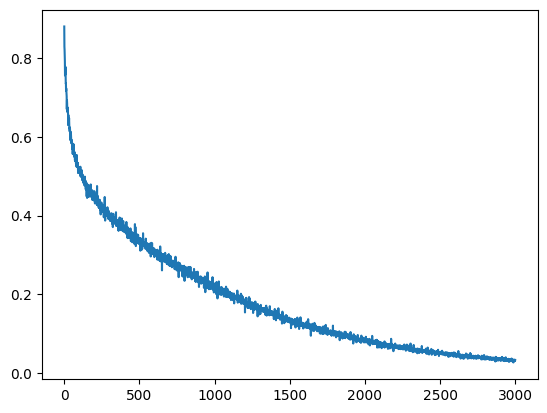

In [19]:
y_pred = predict_1(nn_trained,x_v)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)
plt.figure()
plt.plot(loss)

Epoch: 0 Loss: 0.4222639641405998 Validation F1: [0.22551252847380415, 0.2743362831858407, 0.30990990990990996, 0.3463203463203463, 0.4043715846994535, 0.4081632653061224, 0.4, 0.3707865168539325, 0.22388059701492535] Validation Acc: [0.4662480376766091, 0.6138147566718996, 0.6993720565149136, 0.7629513343799058, 0.8288854003139717, 0.8634222919937206, 0.8916797488226059, 0.9120879120879121, 0.9183673469387755]
Epoch: 2 Loss: 0.2536075848646524 Validation F1: [0.2796992481203007, 0.3051470588235294, 0.3367983367983368, 0.36231884057971014, 0.39106145251396646, 0.41721854304635764, 0.3938223938223938, 0.39449541284403666, 0.3536585365853659] Validation Acc: [0.6240188383045526, 0.7032967032967034, 0.749607535321821, 0.792778649921507, 0.8288854003139717, 0.8618524332810047, 0.8767660910518054, 0.8963893249607535, 0.9167974882260597]
Epoch: 4 Loss: 0.11357894595936015 Validation F1: [0.3458646616541353, 0.38271604938271603, 0.38461538461538464, 0.38056680161943324, 0.36607142857142855, 0

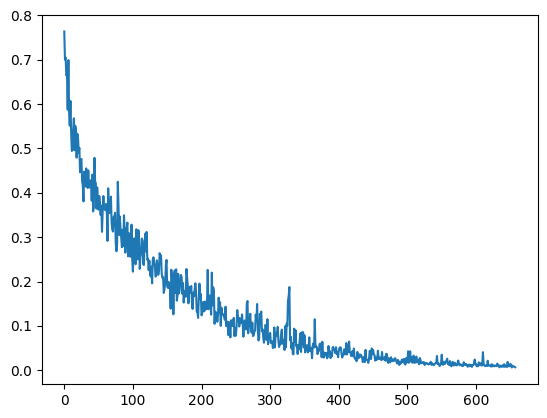

In [11]:
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.8)
x_t, y_t = data_augmentation(x_t, y_t)
# x_t, _, _, _= pca(x_t, 100)
nn = initialize_network(input_size=np.shape(x_t)[1], hidden_size1=512, hidden_size2=128, hidden_size3=32, output_size=1)
nn_trained, loss = train(nn, x_t, y_t, x_v, y_v, learning_rate=0.05, epochs=1000, batch_size=200)
# y_pred = predict_1(nn_trained,x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)
plt.figure()
plt.plot(loss)

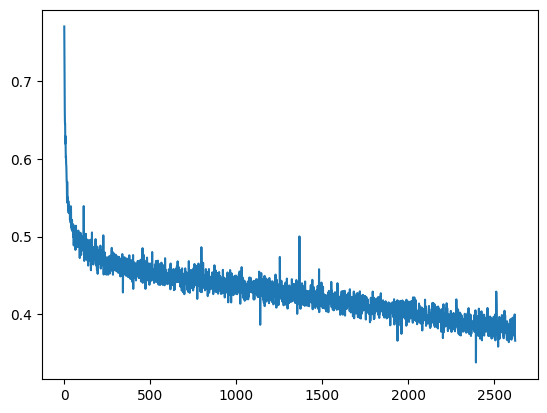

In [12]:
np.savez("./with_one_hot_deeper", network=nn_trained)
nn_trained
plt.figure()
plt.plot(loss)

ValueError: shapes (109379,603) and (568,400) not aligned: 603 (dim 1) != 568 (dim 0)

In [23]:
import pandas as pd
last_pred = pd.read_csv('./submission_NN.csv')
last_pred = last_pred.to_numpy()
print(sum(test_pred==last_pred[:, 1]))
print(test_pred.shape)

99355
(109379,)


In [29]:
a2 = forward_propagation(nn_trained, x_v)[-1]
    
    
y_pred = (np.squeeze(a2) > 0).astype(int)
predict_acc_pure(y_pred, y_v)
predict_f1_pure(y_pred, y_v)


The Accuracy is: 0.0000
The F1 score is: 0.1550
The precision is: 0.0840
The recall is: 1.0000


0.15496017378711077

In [30]:
y_pred = predict(nn_trained,x_v)

In [31]:
y_v.mean()

0.08398744113029827

### Test NN ### 

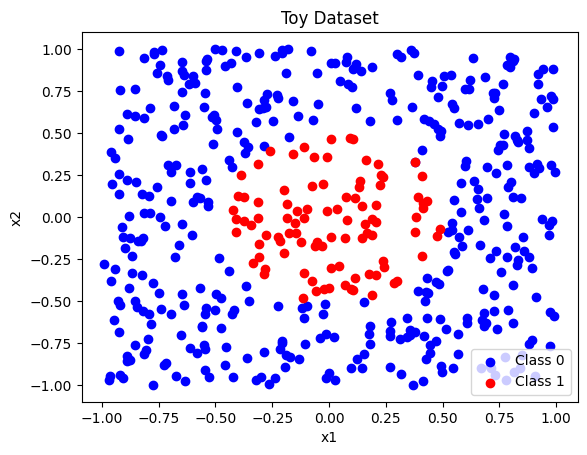

In [3]:
def generate_data(num_samples=500, radius=0.5):
    # Generate random 2D points
    x = np.random.rand(num_samples, 2) * 2 - 1 # Rescale to [-1, 1]
    
    # Create labels based on distance to the origin
    labels = (np.sum(x**2, axis=1) < radius**2).astype(int)
    
    return x, labels

x, y = generate_data()

# Visualization
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Toy Dataset')
plt.show()

### Test NN Class ###

Epoch: 0 Loss: 1.831615047144853 Validation F1: [0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163, 0.16161616161616163] Validation Acc: [0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792, 0.08791208791208792]


/home/ivonne/ML_proj/project1/networks.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch: 2 Loss: 1.3162074562284758 Validation F1: [nan, nan, nan, nan, nan, nan, nan, nan, nan] Validation Acc: [0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121]
Epoch: 4 Loss: 0.5359217574149553 Validation F1: [nan, nan, nan, nan, nan, nan, nan, nan, nan] Validation Acc: [0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121]
Epoch: 6 Loss: 0.3360954882976389 Validation F1: [0.16161616161616163, 0.16161616161616163, nan, nan, nan, nan, nan, nan, nan] Validation Acc: [0.08791208791208792, 0.08791208791208792, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121, 0.9120879120879121]
Epoch: 8 Loss: 0.2742046371857378 Validation F1: [0.16161616161616163, 0.16161616161616163

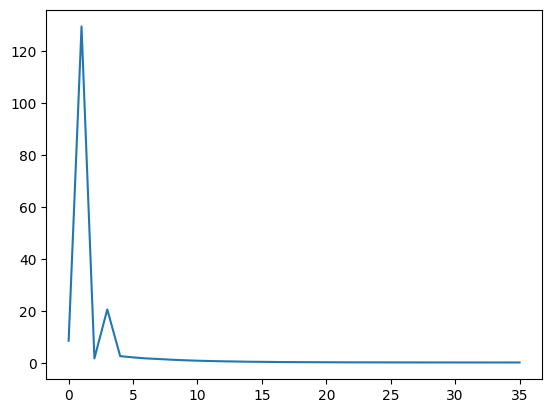

In [16]:
x_t, y_t, x_v, y_v = split_data(x_train_processed, y_train_processed, 0.8)
x_t, y_t = data_augmentation(x_t, y_t)
# x_t, _, _, _= pca(x_t, 100)
nn = NeuralNetwork([np.shape(x_t)[1],400, 400, 200, 10, 1],'linear','mse')
nn_trained, loss = nn.train(x_t, y_t, x_v, y_v, learning_rate=0.05, epochs=1000, batch_size=4062)
# y_pred = predict_1(nn_trained,x_v)
# predict_acc_pure(y_pred, y_v)
# predict_f1_pure(y_pred, y_v)
plt.figure()
plt.plot(loss)

In [6]:
np.savez("./5_layers", network=nn_trained)

### Test Submission ###

In [35]:
nn = NeuralNetwork.from_saved_weights('./5_layers.npz')
best_thre = nn.network[-1]['best_threshold']
test_pred = (forward_propagation(test_network,x_test_processed)[-1].squeeze() > best_thre).astype(int)
test_pred = nn.predict_submission(x_test_processed, custom_threshold=best_thre)
create_csv_submission(test_ids, test_pred, 'submission_5_layer.csv')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
np.unique(test_pred)
np.sum(test_pred==1)  

100048

In [33]:
test_pred.shape

(109379, 4)